<a href="https://colab.research.google.com/github/zoedesimone/wwr-semantic-segmentation/blob/main/WWR_FCN_Training_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#FCN Training Notebook
from the paper Window to Wall Ratio (WWR) Detection using SegFormer.

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from io import BytesIO

import numpy as np
import PIL.Image
from IPython.display import Image, clear_output, display

# PyTorch will be out main tool for playing with neural networks
import torch
import torch.hub
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

# For reproducibility
torch.manual_seed(1234)

# CPU / GPU
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

In [2]:
#@title Download the datasets

!gdown 'https://drive.google.com/uc?id=1JSvx8s8tSPpX_7l6aTZZ0rl4V7ejLCoo'
!unzip images.zip

!gdown 'https://drive.google.com/uc?id=1H0KtVq0q8T_HFTCKU4AthTQt01-UD0Tg'
!unzip annotations.zip

Downloading...
From (original): https://drive.google.com/uc?id=1JSvx8s8tSPpX_7l6aTZZ0rl4V7ejLCoo
From (redirected): https://drive.google.com/uc?id=1JSvx8s8tSPpX_7l6aTZZ0rl4V7ejLCoo&confirm=t&uuid=fc35a9bf-0010-4280-892e-ad3048319101
To: /content/images.zip
100% 61.0M/61.0M [00:00<00:00, 126MB/s]
Archive:  images.zip
  inflating: images/validation/01042.jpg  
  inflating: images/validation/02468.jpg  
  inflating: images/validation/02115.jpg  
  inflating: images/validation/00739.jpg  
  inflating: images/validation/00422.jpg  
  inflating: images/validation/01178.jpg  
  inflating: images/validation/01748.jpg  
  inflating: images/validation/00599.jpg  
  inflating: images/validation/00023.jpg  
  inflating: images/validation/00846.jpg  
  inflating: images/validation/02074.jpg  
  inflating: images/validation/00423.jpg  
  inflating: images/validation/02156.jpg  
  inflating: images/validation/01006.jpg  
  inflating: images/validation/00764.jpg  
  inflating: images/validation/02296.

In [3]:
class ImageAnnotationDataset(Dataset):
    def __init__(self, images, annotations):
        self.images = images
        self.annotations = annotations

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        annotation = self.annotations[idx]

        return image, annotation

In [6]:
image_path = "images"
annotation_path = "annotations"

train_image_path = os.path.join(image_path, 'training')
val_image_path = os.path.join(image_path, 'validation')
test_image_path = os.path.join(image_path, 'testing')

train_ann_path = os.path.join(annotation_path, 'training')
val_ann_path = os.path.join(annotation_path, 'validation')
test_ann_path = os.path.join(annotation_path, 'testing')

to_tensor = transforms.Compose([transforms.Resize((520, 520)), transforms.PILToTensor()])
norm_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_images = []
train_annotations = []

for filename in os.listdir(train_image_path):
    train_images.append(to_tensor(PIL.Image.open(os.path.join(train_image_path, filename)).convert('RGB'))/255)
    filename_annotation = filename.split(".")[0] + '.png'
    annotated = to_tensor(PIL.Image.open(os.path.join(train_ann_path , filename_annotation)).convert('RGB'))
    mask = (annotated[0] != 0).int()
    train_annotations.append(mask)

train_images = torch.stack(train_images)
train_annotations = torch.stack(train_annotations)
norm_train_images = norm_img(train_images.type(torch.float))

val_images = []
val_annotations = []

for filename in os.listdir(val_image_path):
    val_images.append(to_tensor(PIL.Image.open(os.path.join(val_image_path, filename)).convert('RGB'))/255)
    filename_annotation = filename.split(".")[0] + '.png'
    annotated = to_tensor(PIL.Image.open(os.path.join(val_ann_path, filename_annotation)).convert('RGB'))
    mask = (annotated[0] != 0).int()
    val_annotations.append(mask)

val_images = torch.stack(val_images)
val_annotations = torch.stack(val_annotations)
norm_val_images = norm_img(val_images.type(torch.float))

test_images = []
test_annotations = []

for filename in os.listdir(test_image_path):
    test_images.append(to_tensor(PIL.Image.open(os.path.join(test_image_path, filename)).convert('RGB'))/255)
    filename_annotation = filename.split(".")[0] + '.png'
    annotated = to_tensor(PIL.Image.open(os.path.join(test_ann_path, filename_annotation)).convert('RGB'))
    mask = (annotated[0] != 0).int()
    test_annotations.append(mask)

test_images = torch.stack(test_images)
test_annotations = torch.stack(test_annotations)
norm_test_images = norm_img(test_images.type(torch.float))

train_dataset = ImageAnnotationDataset(norm_train_images, train_annotations)
val_dataset = ImageAnnotationDataset(norm_val_images, val_annotations)
test_dataset = ImageAnnotationDataset(norm_test_images, test_annotations)

Upto this point we have loaded the images and the annotations from the file in Google Drive. Next, we have converted the loaded images and annotations to tensors and resized them to have a fixed width and height. This width and height is a hyperparameter choice that depends on what the inital dataset looked like. In this case, a value of 300 was chosen for both. Next, we normalized the images after calculating the mean and std deviation of the dataset. Also, the annotations were converted to binary maps where the background is represented by 0 and a window pixel is 1.

Overall, we have a tensor named normalized_images (number of images, channels, width, height) containing the inputs (channels, width, height) to our models and annotations (number of images, width, height)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [8]:
from torchvision.models.segmentation import fcn_resnet50, deeplabv3_resnet101
#model = deeplabv3_resnet101(weights='COCO_WITH_VOC_LABELS_V1').to(device)
model = fcn_resnet50(weights='COCO_WITH_VOC_LABELS_V1').to(device)
model.classifier[-1] = nn.Conv2d(model.classifier[4].in_channels,1,kernel_size=(1,1),stride=(1,1)).to(device)
model.aux_classifier[-1] = nn.Conv2d(model.aux_classifier[4].in_channels,1, kernel_size=(1,1),stride=(1,1)).to(device)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 125MB/s]


In [9]:
list(model.children())

[IntermediateLayerGetter(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): Bottleneck(
       (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (downsample): Sequential(
         (0): Conv2d(64, 256

In [10]:
def IOU(tensor_1, tensor_2):
    iou_list = []
    for i in range(tensor_1.shape[0]):
      # Compute intersection and union
        intersection = torch.logical_and(tensor_1[i], tensor_2[i])
        union = torch.logical_or(tensor_1[i], tensor_2[i])
      # Compute IoU
        iou = torch.sum(intersection).float() / torch.sum(union).float()

        iou_list.append(iou)

    return iou_list

def IOU_single(tensor_1, tensor_2):
    # Compute intersection and union
    intersection = torch.logical_and(tensor_1, tensor_2)
    union = torch.logical_or(tensor_1, tensor_2)
    # Compute IoU
    iou = torch.sum(intersection).float() / torch.sum(union).float()

    return iou

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.val = val
        self.sum += np.sum(val)
        self.count += len(val)
        self.avg = self.sum / self.count

def train(dataloader, model, optimizer, epoch):
    model.train()
    train_loss = []
    acc_meter = AverageMeter()
    batches = tqdm(enumerate(dataloader), total=len(dataloader))
    batches.set_description("Epoch NA: BCELoss (NA) IOU (NA)")
    for batch_idx, (data, target) in batches:
        # TODO: Move data to appropriate device
        data = data.to(device)
        target = target.to(device)
        # TODO: Zero out gradients
        optimizer.zero_grad()
        # TODO: Compute forward pass, loss, and gradients
        out = model(data)['out']
        out = torch.nn.functional.sigmoid(out)
        crossloss = nn.BCELoss()
        loss = crossloss(out,target.unsqueeze(dim=1).type(torch.float))
        loss.backward()
        # TODO: Update parameters
        optimizer.step()
        train_loss.append(loss.item())
        # TODO: Compute and record accuracy
        #acc = IOU(out.cpu(),target.unsqueeze(dim=1).cpu()) #May need IOU
        #acc_meter.update(acc)

        batches.set_description(
            "Epoch {:d}: BCE Loss ({:.2e})".format(
                epoch, loss.item()
            )
        )

    return np.mean(train_loss)


def get_prediction(image, model):
    pred = model(image)['out']
    pred = torch.nn.functional.sigmoid(pred)
    out = torch.round(pred)

    return out

def flatten(l):
    return [item for sublist in l for item in sublist]

def evaluate(dataloader, model, sort):
    iou_list = []
    model.eval()

    for image, label in dataloader:
        image, label = image.to(device), label.to(device)

        with torch.no_grad():
            # TODO: Get predictions using function from above
            pred = get_prediction(image, model)
            # TODO: Update total and correct
            precision_list = IOU(pred.cpu(), label.unsqueeze(dim=1).cpu())
            iou_list.append(precision_list)

    iou_out_list = flatten(iou_list)


    if sort == 'mean':
      return np.mean(iou_out_list)
    else:
      return iou_out_list



In [13]:
from torch import optim

!mkdir "10percent_dataset_fcn_resnet50_coco_lr_low"
# Fix the places with a TODO
num_epochs = 100
lr = 0.0005

def create_optimizer(net, lr):
    # TODO: Create optimizer
    opt = optim.Adam(net.parameters(), lr=lr)
    return opt

optimizer = create_optimizer(model, lr)

train_loss_list = []
val_iou_list = [0]
trained_model_path = "10percent_dataset_fcn_resnet50_coco_lr_low"
for epoch in range(num_epochs):
    val_iou = evaluate(val_loader, model, 'mean')
    if val_iou > max(val_iou_list):
       checkpoint_path = os.path.join(trained_model_path, f"model_best.pt")
       torch.save(model.state_dict(), checkpoint_path)
    val_iou_list.append(val_iou)
    print('Epoch: {}\tValidation IOU: {:.4f}%'.format(epoch, val_iou))
    train_bce_loss = train(train_loader, model, optimizer, epoch)
    train_loss_list.append(train_bce_loss)

valid_accuracy = evaluate(val_loader, model, 'mean')
print('Done! \tValidation IOU: {:.4f}%'.format(evaluate(val_loader, model, 'mean')))

Epoch: 0	Validation IOU: 0.1695%


Epoch 0: BCE Loss (7.05e-02): 100%|██████████| 112/112 [00:56<00:00,  1.97it/s]


Epoch: 1	Validation IOU: 0.9764%


Epoch 1: BCE Loss (2.80e-02):   7%|▋         | 8/112 [00:04<01:02,  1.67it/s]


KeyboardInterrupt: 

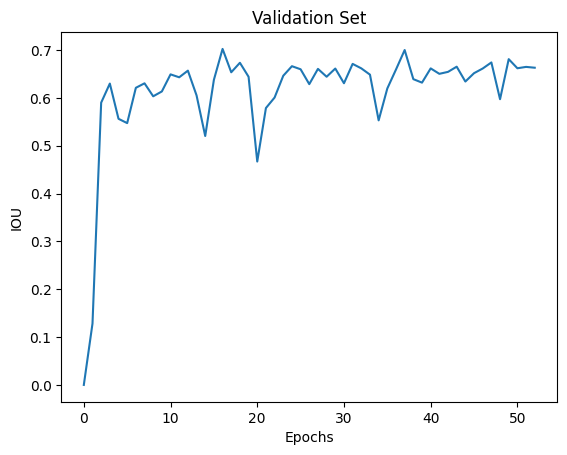

In [ ]:
xs = [x for x in range(len(val_iou_list))]
plt.plot(xs, val_iou_list)
plt.xlabel("Epochs")
plt.ylabel("IOU")
plt.title("Validation Set")
plt.savefig('validation_error_10_percent_100_epochs.png')
plt.show()

In [ ]:
trained_model_path = "10percent_dataset_fcn_resnet50_coco_lr_low"

In [ ]:
#model_2 = deeplabv3_resnet101(weights='COCO_WITH_VOC_LABELS_V1').to(device)
model_2 = fcn_resnet50(weights='COCO_WITH_VOC_LABELS_V1').to(device)
model_2.classifier[-1] = nn.Conv2d(model_2.classifier[4].in_channels,1,kernel_size=(1,1),stride=(1,1)).to(device)
model_2.aux_classifier[-1] = nn.Conv2d(model_2.aux_classifier[4].in_channels,1, kernel_size=(1,1),stride=(1,1)).to(device)
model_2.load_state_dict(torch.load(os.path.join(trained_model_path, f"model_best.pt")))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  prediction = model(norm_test_images.to(device))['out']
  pred_soft = torch.nn.functional.sigmoid(prediction)

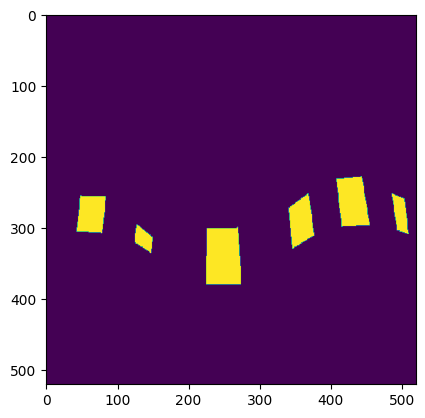

In [ ]:
choice = 5
plt.imshow(test_annotations[choice])

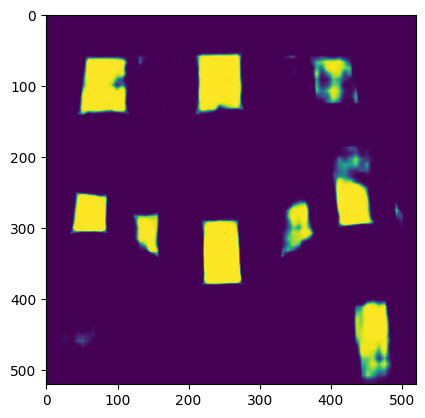

In [ ]:
plt.imshow(pred_soft[choice].cpu().squeeze())

In [16]:
show = transforms.ToPILImage()
q = show(test_images[choice])
q.show()

NameError: name 'choice' is not defined

In [ ]:
test_iou = evaluate(test_loader, model_2, 'mean')

In [ ]:
print(test_iou)

0.6621294


In [14]:
#Custom Image Visualization
!gdown 'https://drive.google.com/uc?id=1IMOCCJNXpwkn0a8Uilcq3gJQcFC-qnob'

my_image_path = "stata.jpg"
to_tensor = transforms.Compose([transforms.Resize((520, 520)), transforms.PILToTensor()])
norm_img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
my_image = to_tensor(PIL.Image.open(my_image_path).convert('RGB'))/255
norm_my_img = norm_img(my_image.type(torch.float))
with torch.no_grad():
  prediction = model_2(norm_my_img.to(device).unsqueeze(dim=0))['out']
  pred_soft = torch.nn.functional.sigmoid(prediction)

plt.imshow(pred_soft.cpu().squeeze())

Downloading...
From: https://drive.google.com/uc?id=1IMOCCJNXpwkn0a8Uilcq3gJQcFC-qnob
To: /content/stata.jpg
100% 767k/767k [00:00<00:00, 134MB/s]


NameError: name 'model_2' is not defined

In [15]:
my_original_image = show(my_image)
my_original_image .show()

NameError: name 'show' is not defined